In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv('loan_features.csv')

In [18]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE 
ss = StandardScaler()
y= df.STATUS
X = df.drop('STATUS',axis = 1)
sm = SMOTE(random_state=0,sampling_strategy=.15)
X, y = sm.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=0)
X_train = ss.fit_transform(X_train)
X_test = ss.fit_transform(X_test)
rf = RandomForestClassifier(random_state = 0) #,class_weight = {0:100,1:1})
rf.fit(X_train, y_train);

In [19]:
from sklearn.metrics import classification_report
target_names = ['Unfunded','Funded']
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

    Unfunded       0.37      0.75      0.49     64074
      Funded       0.96      0.81      0.88    430715

    accuracy                           0.80    494789
   macro avg       0.66      0.78      0.68    494789
weighted avg       0.88      0.80      0.83    494789



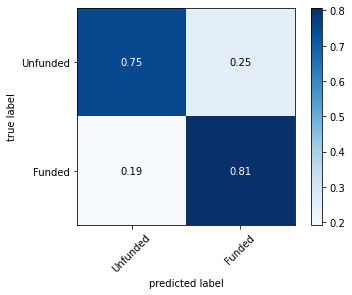

In [20]:
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
cm = confusion_matrix(y_test, y_pred, labels=rf.classes_)
figure, ax = plot_confusion_matrix(conf_mat = cm,
                                   class_names = target_names,
                                   show_absolute = False,
                                   show_normed = True,
                                   colorbar = True)